In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_parquet(f'train_data.parquet')
print(len(train_df))

178340


In [ ]:
# Get columns that are IV-related (call_iv or put_iv)
iv_cols = [col for col in train_df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

# Create a boolean mask for valid rows (all IV values between 0 and 100 inclusive)
# valid_rows_mask = ~((train_df[iv_cols] < 0) | (train_df[iv_cols] > 10)).any(axis=1)
valid_rows_mask = ~((train_df[iv_cols] < 0)).any(axis=1)

# Apply mask to filter the DataFrame
clean_df = train_df[valid_rows_mask].copy()

print(f"Removed {len(train_df) - len(clean_df)} invalid rows.")

Removed 299 invalid rows.


In [14]:
X = clean_df.drop(columns=iv_cols)
y = clean_df[iv_cols]

In [ ]:
X['timestamp'] = pd.to_datetime(X['timestamp'])
X['expiry'] = pd.to_datetime(X['expiry'])
# X['days_to_expiry'] = (X['expiry'] - X['timestamp']).dt.days
X = X.drop(columns=['timestamp', 'expiry'])

# PCA

In [87]:
X = clean_df.drop(columns=['call_iv_24500'])
y = clean_df['call_iv_24500']
X = X.drop(columns=['timestamp', 'expiry'])
print((X.columns))

Index(['underlying', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700',
       'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24600',
       'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000',
       'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400',
       'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800',
       'call_iv_25900', 'call_iv_26000', 'put_iv_22500', 'put_iv_22600',
       'put_iv_22700', 'put_iv_22800', 'put_iv_22900', 'put_iv_23000',
       'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400',
       'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800',
       'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200',
       'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600',
       'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000', 'X0',
       'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


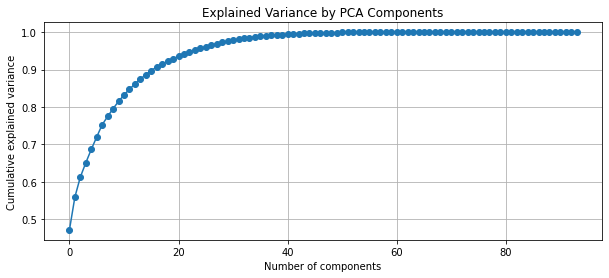

In [90]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.title("Explained Variance by PCA Components")
plt.show()


In [91]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 24


In [92]:
loading_matrix = pca.components_.T  # shape: (n_features, n_components)
feature_importance = np.abs(loading_matrix[:, :n_components]).sum(axis=1)
feature_scores = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

# Top 20 most influential original features
top_features = feature_scores.head(50)
print(top_features)


X12              3.368773
X8               3.271930
X37              3.226900
X4               3.100194
X10              3.009725
X7               2.986069
X3               2.858107
X11              2.783684
X6               2.692003
X17              2.679210
X35              2.582666
X19              2.569756
X30              2.547741
X36              2.515951
X26              2.508419
X40              2.502644
X13              2.500595
X18              2.492402
X33              2.460059
X41              2.438922
X20              2.417166
X34              2.414004
X27              2.412765
X16              2.370106
X1               2.356553
X21              2.356333
X22              2.354969
X23              2.342931
X14              2.333308
X39              2.330768
X9               2.264442
X32              2.262363
X28              2.252286
X24              2.249382
X25              2.233688
X2               2.143262
X0               2.125207
X29              2.111793
underlying  

In [ ]:
top_feature_names = top_features.index.tolist()
X = X[top_feature_names]
y1 = y[['call_iv_23500', 'put_iv_23500']]

In [97]:
correlations = clean_df.corr(numeric_only=True)["call_iv_24600"].drop("call_iv_24600").sort_values(ascending=False)

In [98]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(correlations)

call_iv_24700    0.995141
put_iv_24600     0.995056
put_iv_24700     0.988995
call_iv_24800    0.986712
put_iv_24800     0.986341
call_iv_24500    0.983982
put_iv_24500     0.982484
call_iv_24900    0.977955
call_iv_25000    0.970525
put_iv_25000     0.969546
put_iv_24900     0.968751
call_iv_25100    0.962704
call_iv_25200    0.957713
call_iv_25300    0.953105
call_iv_25400    0.949805
call_iv_25500    0.947611
call_iv_25600    0.944102
call_iv_25700    0.942534
call_iv_25800    0.941680
call_iv_25900    0.939433
call_iv_26000    0.938038
put_iv_22500     0.905139
call_iv_23500    0.904660
put_iv_22600     0.904290
put_iv_22700     0.903337
put_iv_22800     0.902151
put_iv_22900     0.900058
call_iv_23700    0.899576
put_iv_23000     0.896907
put_iv_23100     0.894884
put_iv_23200     0.892917
put_iv_23300     0.889603
put_iv_23400     0.884540
put_iv_23500     0.883042
put_iv_23600     0.878716
put_iv_23700     0.874450
put_iv_23800     0.869918
call_iv_23600    0.866130
call_iv_2390

# Regression - Random Forest

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(RandomForestRegressor(random_state=0))
%time model.fit(X_train, y1_train)


CPU times: total: 8min 24s
Wall time: 10min 52s


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=0))

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y1_test, y_pred)
mse = mean_squared_error(y1_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")

MAE: 0.1027
MSE: 0.0269


# Regression - XGBoost

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
print(len(y.columns))

52


In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=15,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

multioutput_model = MultiOutputRegressor(xgb_model)
multioutput_model.fit(X, y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                      

In [ ]:
y_pred = multioutput_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (Overall): {mae:.4f}")

Mean Absolute Error (Overall): 0.0835


In [ ]:
per_column_mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
for col, error in zip(y.columns, per_column_mae):
    print(f"{col}: MAE = {error:.4f}")

call_iv_23500: MAE = 0.1039
call_iv_23600: MAE = 0.0870
call_iv_23700: MAE = 0.0778
call_iv_23800: MAE = 0.0611
call_iv_23900: MAE = 0.0460
call_iv_24000: MAE = 0.0378
call_iv_24100: MAE = 0.0260
call_iv_24200: MAE = 0.0168
call_iv_24300: MAE = 0.0120
call_iv_24400: MAE = 0.0147
call_iv_24500: MAE = 0.0224
call_iv_24600: MAE = 0.0316
call_iv_24700: MAE = 0.0418
call_iv_24800: MAE = 0.0520
call_iv_24900: MAE = 0.0626
call_iv_25000: MAE = 0.0728
call_iv_25100: MAE = 0.0840
call_iv_25200: MAE = 0.0946
call_iv_25300: MAE = 0.1048
call_iv_25400: MAE = 0.1154
call_iv_25500: MAE = 0.1243
call_iv_25600: MAE = 0.1343
call_iv_25700: MAE = 0.1444
call_iv_25800: MAE = 0.1534
call_iv_25900: MAE = 0.1630
call_iv_26000: MAE = 0.1722
put_iv_22500: MAE = 0.1981
put_iv_22600: MAE = 0.1878
put_iv_22700: MAE = 0.1771
put_iv_22800: MAE = 0.1668
put_iv_22900: MAE = 0.1567
put_iv_23000: MAE = 0.1466
put_iv_23100: MAE = 0.1370
put_iv_23200: MAE = 0.1268
put_iv_23300: MAE = 0.1164
put_iv_23400: MAE = 0.1060
pu

# Result on test data

In [ ]:
test_df = pd.read_parquet(f'test_data.parquet')
print(len(test_df))

In [ ]:
y_test = test_df[iv_cols]
X_test = test_df.drop(columns=iv_cols)

In [60]:
y_pred = multioutput_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Overall): {mse:.4f}")

Mean Squared Error (Overall): 0.0241
